In [164]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from domain_transform import DomainTransform
from skimage.io import imread

dt = DomainTransform()

In [165]:
lmbd = 0.99

In [176]:
def derivative(zi, confidence, target, reference, lmbd):
    return lmbd*(zi - reference) + confidence*(zi - target)    

In [177]:
def cost(zi, confidence, target, reference, lmdb):
    cost_matrix1 = np.power(zi - reference, 2)
    cost_matrix2 = confidence*np.power(zi - target, 2)
    sum1 = (lmbd/2)*np.sum(np.sum(cost_matrix1, axis=0), axis=0)
    sum2 = np.sum(np.sum(cost_matrix2, axis=0), axis=0)
    return sum1 + sum2

In [178]:
reference = imread('depth_superres/reference.png')
reference = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)/ 255.0
target = imread('depth_superres/target.png')
confidence = imread('depth_superres/confidence.png')

Convert to domain [0,1] as bilateral solver example

In [204]:
t = target.astype(np.double)/(pow(2,16)-1)
c = confidence.astype(np.double)/(pow(2,16)-1)

Joint filtering the target map using the reference as parameter(The same way described in the DT paper).
This is equivalent to equation (10) in DTSolver

In [205]:
filtered_target = dt.normalized_convolution(t, 200, 0.25, 3, reference)

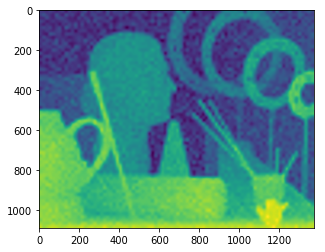

In [233]:
plt.imshow(target)

### Sample of one iteration 

In [207]:
zi = t

In [232]:
cost1 = cost(zi, c, t, filtered_target, lmbd)
cost1

266.13775546766897

Derivative

In [209]:
der = derivative(zi, c, t, filtered_target,lmbd)

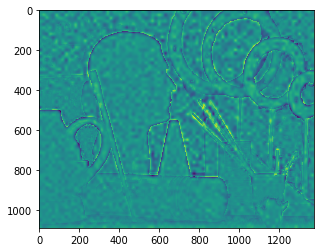

In [210]:
plt.imshow(der)

First gradient descent iteration

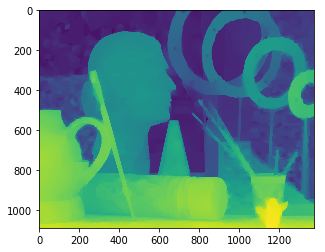

In [211]:
zi = zi - 0.99*der
plt.imshow(zi)

Second iteration

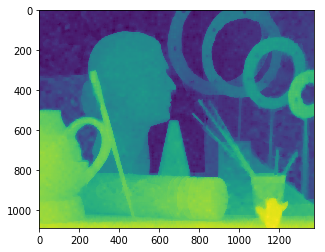

In [230]:
der = derivative(zi, c, t, filtered_target,lmbd)
zi = zi - 0.99*der
plt.imshow(zi)

It begins to display the confidence as the second term of the error in F is not zero anymore